## School project - 5DEEP
The following notebook has been created for a school project on audio classification. The subject and the questions are available in the appendix.

The group members who participated in this project are:
- AMIMI Lamine
- BEZIN Théo
- LECOMTE Alexis
- PAWLOWSKI Maxence

### Main index
1. **Data analysis (you are here)**
2. Data preprocessing
3. Basic ANN model
4. The CNN model
5. The model competition
6. Data augmentation
7. _Appendix_

# 1 - Data analysis
The purpose of this first notebook will be to analyze the data from the dataset, to draw distribution graphs and to discuss the normalizations that will have to be applied on the audio files in order to achieve a satisfactory classification score.

### Index
<ol type="A">
  <li>The dataset</li>
  <li>Terminology</li>
  <li>Notebook initialization</li>
  <li>Data exploration</li>
  <li>Conclusion of the data analysis</li>
</ol>

## A - The dataset
This project will use the URBANSOUND8K DATASET. As stated on the [dataset website](https://urbansounddataset.weebly.com/urbansound8k.html), it contains 8,732 labeled excerpts of up to four seconds in length. These sounds were recorded in an urban area and are classified into ten classes:

- Air conditioner
- Car horn
- Children playing
- Dog barking
- Drilling
- Engine idling
- Gun shot
- Jackhammer
- Siren
- Street music

All excerpts were downloaded from [www.freesound.org](https://www.freesound.org) and presorted into ten folds. An additional CSV file containing metadata about each extract is also provided.

### A.1 - Dataset metadata
The dataset provides a metadata file containing all the information about each audio file, except the characteristics of the audio file itself (sampling rate, bit depth, ...).
- **slice_file_name:** The name of the audio file. Details about the name format can be found on the dataset's website.
- **fsID:** The Freesound ID of the recording from which this excerpt (slice) is taken.
- **start:** The start time of the slice in the original recording.
- **end:** The end time of the slice in the original recording.
- **salience:** A subjective salience rating of the sound. (1 = foreground, 2 = background)
- **fold:** The fold number (1-10).
- **classID:** A numeric identifier of the sound class. The complete list can be found on the dataset's website.
- **class:** The sound class name. The complete list can be found on the dataset's website.

### A.2 - Rules to follow
The provider of the dataset has set certain ground rules that must be followed. This is necessary to ensure that our model is comparable to all other research done on this dataset.

<div style="margin: 20px 0; padding: 10px; background-color: #D9EDF7; color: #31708F; border-left: solid #31708F 4px; border-radius: 4px">
    <span>
        <p style="margin-top: 0; text-align: left;"><b>Note</b></p>
        <p style="margin-bottom: 0;">
            These rules should only be followed if we want to compare our results with other research papers on the same data set. In our case, we will use a different method. Therefore, our performance score cannot be compared with other models outside our notebooks.
        </p>
    </span>
</div>

1. **The data should not be reshuffled.** Reshuffling can inflate the model scores and flaw the performance of our model.
2. **The data should be evaluated using "10-fold cross-validation".** Each of the folds has different levels of classification difficulty for the model. Using another technique may also lead to inflated scores and incorrect results.

## B - Terminology
Before we go any further, let's define some words we will use in this notebook.

- **Frequency:** The number of occurrences of a repeating event per unit of time. The frequency is measured in hertz (Hz) which is equal to one event per second.
- **Audio frequency:** A periodic vibration whose *frequency* is audible to the average human. Like the *frequency*, the SI unit is the hertz (Hz). It is the property of sound that most determines pitch.
- **Amplitude:** The amplitude of a periodic variable is a measure of its change in a single unit of time (period).

    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8a/Sine_voltage.svg/600px-Sine_voltage.svg.png" width="250">

    _1. Peak amplitude ($û$)_
    _2. Peak-to-peak amplitude ($2û$)_
    _3. Root mean square amplitude ($û/\sqrt{2}$)_
    _4. Wave period (not an amplitude)_

- **Channels:** An audio channel is an audio source. The number of channels determines the type of audio file:
    - <u>Monophonic sound reproduction (mono):</u> A sound intended to be heard as if it were emanating from one position. Monaural sound has largely been replaced by *stereo* sound, but remains the standard for radiotelephone communications, telephone networks and audio induction loops for use with hearing aids.
    - <u>Stereophonic sound (stereo):</u> A method that recreates a multi-directional, 3-dimensional audible perspective. This is usually achieved by using two independent audio channels through a configuration of two speakers in a such way as to create the impression of sound heard from various directions, as in natural hearing.
    - <u>Surround sound:</u> A technique for enriching the fidelity and depth of sound reproduction by using multiple audio channels from speakers. This term is often used for systems that use more than two audio channels, such as movie theaters that use a 16.2 surround system.
- **Sample:** A sample is a value of the signal at a point in time and/or space.
- **Sampling rate:** The average number of *samples* obtained in one second, thus $f_{s} = 1/T$. Like the *frequency*, the SI unit is the hertz (Hz). The sampling rate used on most TVs is 48 kHz, which means 48,000 *samples* per second.

## C - Notebook initialization
The following code blocks will be replicated in the next notebooks. Their main purpose is to import the necessary packages, initialize some of them and define a bunch of constants and utility functions used in the project. A small explanation will be added to each block of code, but will then be omitted to avoid repetition.

### C.1 - Imports
Here we import all used packages. This prevents some imports from being hidden in another piece of code and ensures that nothing is imported twice.

In [2]:
# OS and filesystem
import os
import sys
from pathlib import Path

# Data
import pandas
from matplotlib import pyplot

# Sound processing
import librosa
import librosa.display

# Console output
from colorama import Fore, Style
from tqdm.notebook import tqdm

# Misc.
import struct

# Local files
sys.path.append(os.path.join(os.pardir, os.pardir))
import helpers

### C.2 - Package initialization
We define the style of the graphs generated by the Matplotlib library to facilitate quick identification of trends and patterns in the data and to effectively communicate the results.

In [3]:
pyplot.style.use("ggplot")  # Set the matplotlib style

### C.3 - Constants
We also define some constants used in this notebook. If you clone this project, be careful when changing these constants and remember to apply the changes in all notebooks. You may notice that we have defined a random state. Although it is never used for final models, it is useful when we try to compare the performance of different models on the same dataset.

In [4]:
# Filesystem paths
PARENT_FOLDER = Path.cwd()
DATA_FOLDER = (PARENT_FOLDER / ".." / ".." / "data").resolve()
URBAN_DATASET_FOLDER = DATA_FOLDER / "UrbanSound8K"
MODELS_FOLDER = (PARENT_FOLDER / ".." / ".." / "models").resolve()
TEMP_FOLDER = (PARENT_FOLDER / ".." / ".." / "temp").resolve()

# Matplotlib
PLOT_COLORS = pyplot.rcParams["axes.prop_cycle"].by_key()["color"]

# Dataset
CLASSES = ["air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]
N_MELS = 128

# Misc.
RANDOM_STATE = 2077

### C.4 - Dataset loading
We load the metadata file provided with the dataset, and perform a simple check to ensure that each file is present in the correct folder. The integrity check only concerns the presence of a file with a given name in the associated fold folder. The verification does not concern the type of file or its readability.

In [5]:
data = pandas.read_csv(URBAN_DATASET_FOLDER / "metadata" / "UrbanSound8K.csv")
print(f"{data.shape[0]} rows, {data.shape[1]} columns")
data.head(n=5)

8732 rows, 8 columns


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [6]:
def verify_dataset_integrity(df: pandas.DataFrame) -> None:
    missing_files_count = 0

    # Loop on each row
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Checking the dataset integrity..."):
        file_path = helpers.urban_df.get_full_path(dataset_folder=URBAN_DATASET_FOLDER, fold=row["fold"], file_name=row["slice_file_name"])

        # Check if the file path exist and if the last item of the path is a file
        if not file_path.is_file():
            missing_files_count += 1
            print(f"{Style.DIM}{Fore.WHITE}Missing file at \"{file_path}\"{Style.RESET_ALL}")

    if missing_files_count == 0:
        print(f"{Fore.GREEN}Successful verification of the dataset. No missing files were detected.{Style.RESET_ALL}")
    else:
        print(f"{Fore.YELLOW}Successful verification of the dataset. {missing_files_count} file{'s are ' if missing_files_count > 1 else ' is '} missing. You should consider re-downloading the dataset.{Style.RESET_ALL}")


verify_dataset_integrity(df=data)

Checking the dataset integrity...:   0%|          | 0/8732 [00:00<?, ?it/s]

Successful verification of the dataset. No missing files were detected.


## D - Data exploration
### D.1 - Null and empty values
We begin this analysis by checking the rate of missing data in the dataset.

In [7]:
def missing_values(df, keep_zeros=True):
    data_count = df.shape[0] * df.shape[1]
    missing = missing_df = df.isna().sum()

    if not keep_zeros:
        missing_df = missing_df[missing_df > 0]

    missing_df = missing_df.sort_values(ascending=False).apply(lambda m: f"{m} ({round((m * 100) / df.shape[0], 2)}%)")

    print((
        f"{Style.BRIGHT}Missing values:{Style.RESET_ALL} {round((missing.sum() / data_count) * 100, 2)}%\n"
        f"{Style.DIM}{Fore.WHITE}{missing_df}{Style.RESET_ALL}"
    ))


missing_values(df=data, keep_zeros=True)

Missing values: 0.0%
slice_file_name    0 (0.0%)
fsID               0 (0.0%)
start              0 (0.0%)
end                0 (0.0%)
salience           0 (0.0%)
fold               0 (0.0%)
classID            0 (0.0%)
class              0 (0.0%)
dtype: object


We can see that the dataset is not missing any values. This will simplify the preprocessing of the data.

### D.2 - Duplicated values
We then check if the dataset contains any duplicated rows. These rows must be removed before further analysis.

In [8]:
def duplicated_values(df):
    data_count = df.shape[0] * df.shape[1]
    duplicated = df.duplicated().sum()

    print(f"{Style.BRIGHT}Duplicated values:{Style.RESET_ALL} {duplicated} ({round((duplicated.sum() / data_count) * 100, 2)}%)")


duplicated_values(df=data)

Duplicated values: 0 (0.0%)


In addition to having no missing values, this dataset has no duplicate rows.

### D.3 - Viewing the sound files
We extract an equivalent number of sounds per class, and draw each waveform. This function allow us to create plots that are easily comparable to each other.

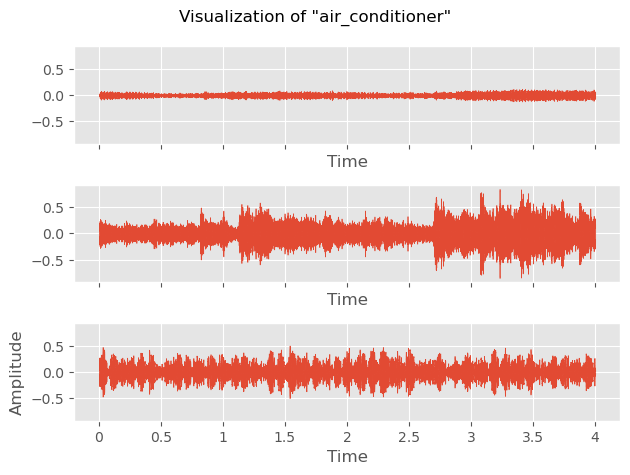

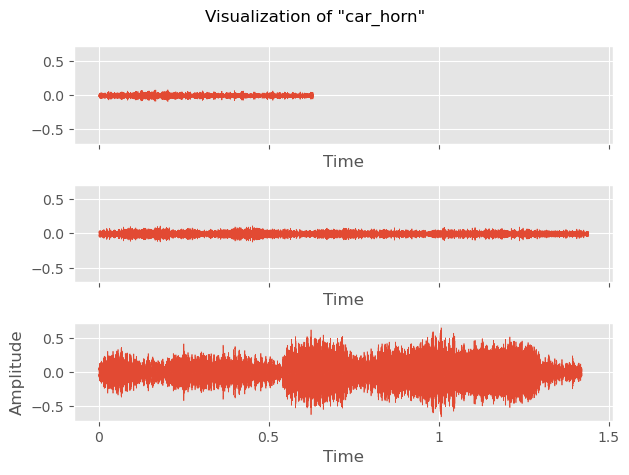

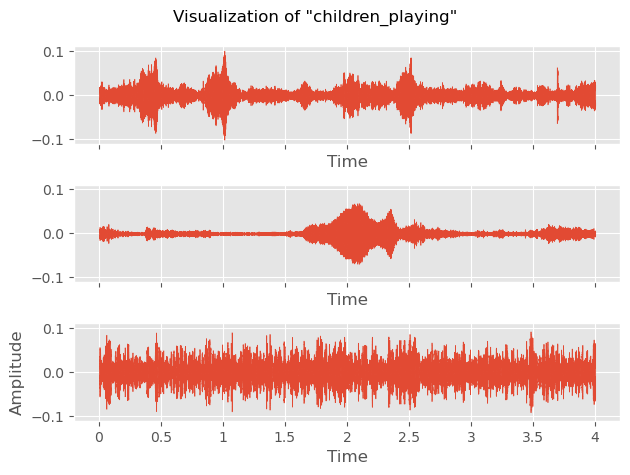

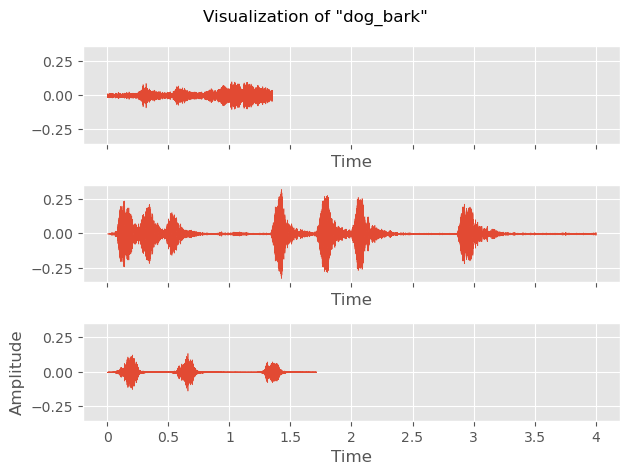

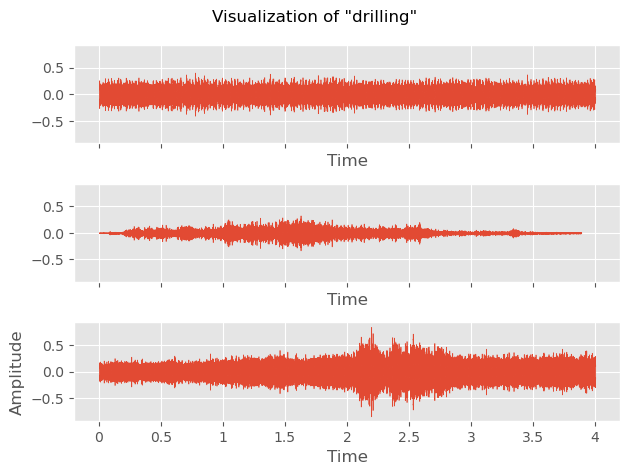

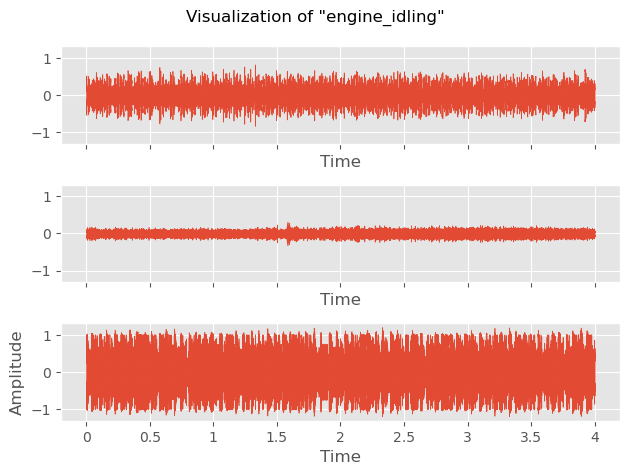

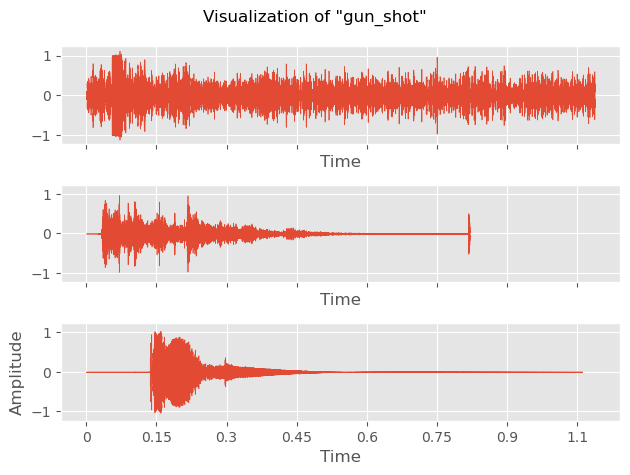

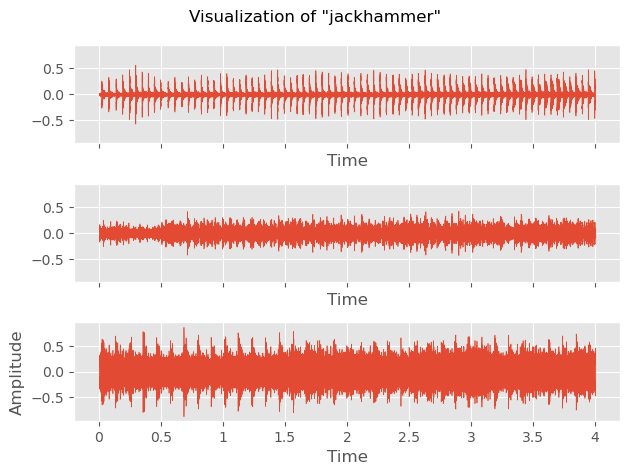

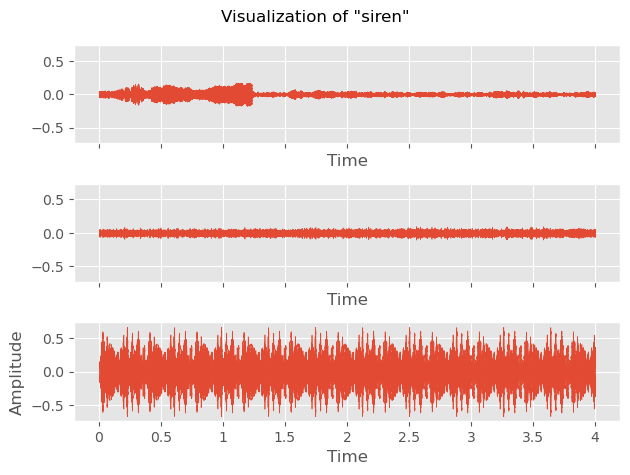

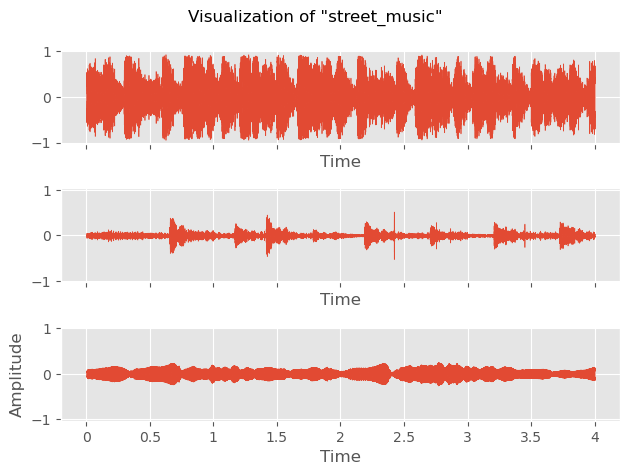

In [9]:
def visualize_audio_classes(samples_size: int = 3) -> None:
    # Get random samples
    samples_end_class = "END"
    random_samples = data.groupby("class").apply(lambda x: x.sample(samples_size))
    random_samples.loc[(samples_end_class, 0), ["fold"]] = 0  # Add an empty row at the end
    random_samples = random_samples.astype({"fold": int})  # Reconvert the fold column to int

    # Initialize loop variables
    fig = axs = last_class = None
    plot_index = 0

    for index, row in random_samples.iterrows():
        class_name = index[0]

        # Start a new figure at new class
        if last_class != class_name:
            if fig is not None:
                fig.suptitle(f"Visualization of \"{last_class}\"")
                pyplot.xlabel("Time")
                pyplot.ylabel("Amplitude")
                pyplot.tight_layout()
                pyplot.show()

            if class_name != samples_end_class:
                fig, axs = pyplot.subplots(samples_size, 1, sharex="all", sharey="all")
                last_class = class_name
                plot_index = 0

        # Load the audio file and draw the graph
        if class_name != samples_end_class:
            samples, sampling_rate = helpers.urban_df.load_audio(dataset_folder=URBAN_DATASET_FOLDER, fold=row["fold"], file_name=row["slice_file_name"])
            librosa.display.waveshow(samples, sr=sampling_rate, ax=axs[plot_index])

            plot_index += 1


visualize_audio_classes()

By comparing the different graphs, we can distinguish certain characteristics for each sound. The jackhammer has frequent short sounds of high amplitude followed by a brief silence, an idling engine is much more linear. We also notice that some class sounds are similar in amplitude. In our case, if we compare the sound of the class `engine_idling` and `air_conditioner`, we notice a rather similar amplitude.

The waveform does not give any information about the frequencies, so it is impossible at this stage of the study to completely solve the problem of classifying urban sounds by just looking at the waveforms.

### D.4 - Sound class distribution
The sound classes are very important because the model will train on them. An imbalance could lead to a model with classification difficulties on the least represented types of sounds in this dataset. We must therefore check the distribution of the classes in order to anticipate a possible drop in performance when classifying certain sounds.

dog_bark            11.5%
children_playing    11.5%
air_conditioner     11.5%
street_music        11.5%
engine_idling       11.5%
jackhammer          11.5%
drilling            11.5%
siren               10.6%
car_horn             4.9%
gun_shot             4.3%
Name: class, dtype: object


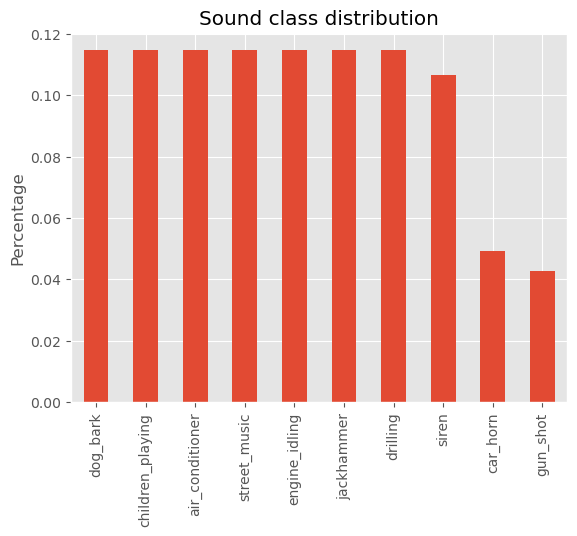

In [10]:
class_distribution = data["class"].value_counts(normalize=True)
class_distribution_list = class_distribution.mul(100).round(1).astype(str) + "%"

class_distribution.plot(kind="bar", title="Sound class distribution", ylabel="Percentage")
print(class_distribution_list)

We notice that two classes (car_horn and gun_shot) are lower in terms of number of data, while the rest have a rather balanced distribution. This could lead to an imbalance in the model training.

### D.5 - Extraction of sound characteristics
For the following distribution analyses, we need data about the sound files themselves. We will read each sound file using Python's `read` function instead of `librosa` to extract their characteristics. This is due to the inability of `librosa` to read the bit depth of an audio file. We use the header of the WAVE file to extract the sampling rate, the bit depth and the number of channels. You can read more about the WAVE header [here](http://soundfile.sapp.org/doc/WaveFormat/).

The newly created dataset is then saved for later use, even after the Jupyter server is closed.

In [11]:
def extract_characteristics(df: pandas.DataFrame) -> pandas.DataFrame:
    data_audio_files = []

    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Extracting characteristics..."):
        file_name = str(row["slice_file_name"])
        fold = int(row["fold"])
        class_name = str(row["class"])
        duration = float(row["end"]) - float(row["start"])

        # See [http://soundfile.sapp.org/doc/WaveFormat/] for details about the WAVE header
        wave = open(file=helpers.urban_df.get_full_path(dataset_folder=URBAN_DATASET_FOLDER, fold=fold, file_name=file_name), mode="rb")  # Reading the file
        _ = wave.read(12)  # Reading the RIFF chunk descriptor
        fmt = wave.read(36)  # Reading the fmt sub-chunk

        sampling_rate = struct.unpack("<I", fmt[12:16])[0]  # Extract the sampling rate (24:28)
        bit_depth = struct.unpack("<H", fmt[22:24])[0]  # Extract the bit depth (34:36)
        num_channels = struct.unpack("<H", fmt[10:12])[0]  # Extract the channel count (22:24)

        data_audio_files.append((file_name, fold, class_name, duration, sampling_rate, bit_depth, num_channels))

    return pandas.DataFrame(data_audio_files, columns=["file_name", "fold", "class", "duration", "sampling_rate", "bit_depth", "num_channels"])


data_audio = extract_characteristics(df=data)
data_audio.to_csv(DATA_FOLDER / "data-audio-characteristics_12-02-23_16-11.csv")

Extracting characteristics...:   0%|          | 0/8732 [00:00<?, ?it/s]

### D.6 - Channel count distribution

   num_channels  count
0             1    739
1             2   7993


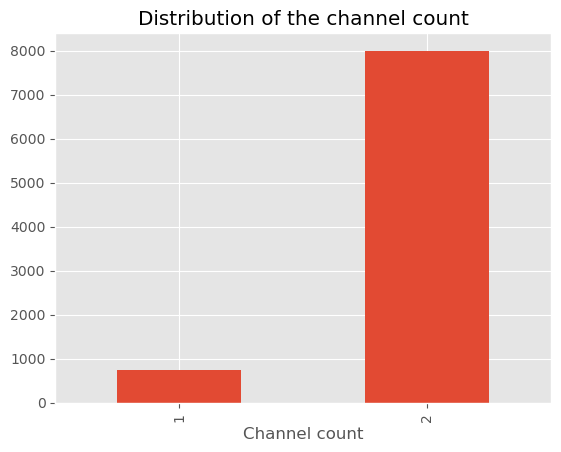

In [12]:
channel_count_distribution = data_audio.groupby(["num_channels"]).size().reset_index(name="count")

channel_count_distribution.plot(kind="bar", x="num_channels", xlabel="Channel count", title="Distribution of the channel count", legend=False)
print(channel_count_distribution)

Most audio files are stereo, but a small portion of them are mono. To normalize the number of channels, we will convert each audio file to mono by merging the stereo channels into a single channel.

### D.7 - Sampling rate distribution

    sampling_rate  count
0            8000     12
1           11024      7
2           11025     39
3           16000     45
4           22050     44
5           24000     82
6           32000      4
7           44100   5370
8           48000   2502
9           96000    610
10         192000     17


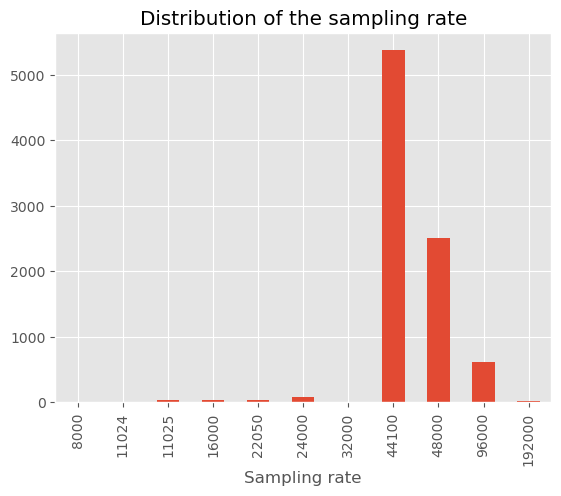

In [13]:
sampling_rate_distribution = data_audio.groupby(["sampling_rate"]).size().reset_index(name="count")

sampling_rate_distribution.plot(kind="bar", x="sampling_rate", xlabel="Sampling rate", title="Distribution of the sampling rate", legend=False)
print(sampling_rate_distribution)

Most files are sampled at 44.1 kHz, but there is a huge disparity. The lowest sampling rate is 8 kHz (extremely low quality) while the highest is 192 kHz (professional recording).

### D.8 - Sound duration distribution

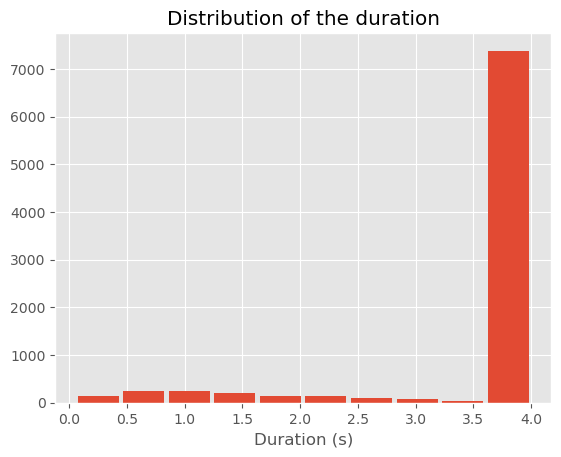

In [14]:
pyplot.hist(data_audio["duration"], rwidth=0.9)

pyplot.xlabel("Duration (s)")
pyplot.title("Distribution of the duration")
pyplot.show()

As with the other distribution graphs, there is a strong disproportion between the length of the audio files.

### D.9 - Bit depth distribution

   bit_depth  count
0          4      9
1          8     43
2         16   5758
3         24   2753
4         32    169


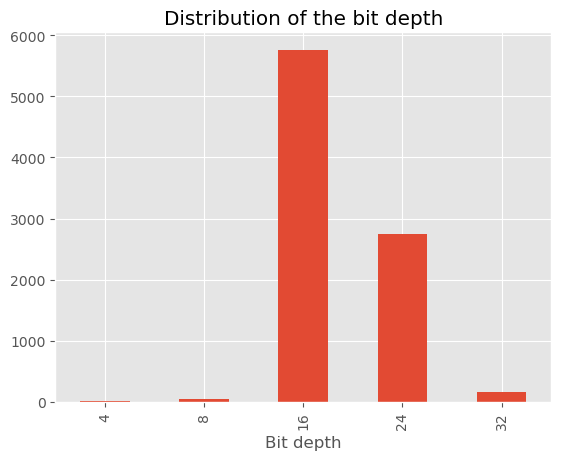

In [15]:
bit_depth_distribution = data_audio.groupby(["bit_depth"]).size().reset_index(name="count")

bit_depth_distribution.plot(kind="bar", x="bit_depth", xlabel="Bit depth", title="Distribution of the bit depth", legend=False)
print(bit_depth_distribution)

There is a very noticeable difference between 4/8-bit audio (old game sound) and 16-bit audio (CD quality). Fortunately for us, most files have a bit depth of at least 16-bits, which guarantees a good reproduction of the sound as perceived by the human ear.

## E - Conclusion of the data analysis
The analysis of the dataset allows us to observe several things. The metadata are complete and contain no duplicates. There is no need to filter or normalize these data.

However, the audio files were much more anarchic and disparate in terms of sound quality, duration and recording method. These differences induce new variables that the model could take into account without really making sense for the classification. A longer sound is not always a jackhammer. The number of channels in a sound is also not a way to classify that sound. It is therefore necessary to smooth out these differences, either by filtering or by normalization.

Filtering would allow us to keep all stereo sounds with a satisfactory sound quality. However, this would lead to a considerable loss of data. The dataset already contains only 8,732 recordings. Shortening it further could compromise the learning of the model.

The most sensible solution then seems to be normalization. A part of the files will be normalized downwards. A lower sampling rate or the loss of a channel would affect the sound quality of the file. Despite this, the sound is still recognizable and the model will still be able to identify its features.

In the next notebook, we will discuss the pre-processing of the data and the constitution of the training and test sets that will then be used to train our models.